source: https://sofifa.com/

# Imports

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import re

# Data loading and pre-processing

## Data cleaning

In [164]:
df = pd.read_csv('Fifa2022-Males.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 104 entries, sofifa_id to gk
dtypes: float64(18), int64(44), object(42)
memory usage: 15.3+ MB


In [165]:
df.columns.tolist()

['sofifa_id',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'moveme

In [166]:
main_position = []

position_info = {
    "RF":"Forward",
    "CF":"Forward",
    "LF":"Forward",
    "RS":"Forward",
    "ST":"Forward",
    "LS":"Forward",
    "LW":"Forward",
    "RW":"Forward",
    "RDM":"Middle",
    "RCDM":"Middle",
    "CDM":"Middle",
    "LCDM":"Middle",
    "LDM":"Middle",
    "RWM":"Middle",
    "RM":"Middle",
    "RCM":"Middle",
    "CM":"Middle",
    "LCM":"Middle",
    "LM":"Middle",
    "LWM":"Middle",
    "RAM":"Middle",
    "RCAM":"Middle",
    "CAM":"Middle",
    "LCAM":"Middle",
    "LAM":"Middle",
    "SW":"Back",
    "RWB":"Back",
    "RB":"Back",
    "RCB":"Back",
    "CB":"Back",
    "LCB":"Back",
    "LB":"Back",
    "LWB":"Back",
    "GK":"Goalkeeper"
}

for i in range(len(df)):
    if(df['club_position'][i] in position_info):
        main_position.append(position_info.get(df['club_position'][i]))
    elif (df['nation_position'][i] in position_info):
        main_position.append(position_info.get(df['nation_position'][i]))
    else:
        position_list = df['player_positions'][i].replace(" ", "").split(",")
        temp = []
        for j in range(len(position_list)):
            temp.append(position_info.get(position_list[j]))
        main_position.append(max(set(list), key = list.count))

TypeError: 'type' object is not iterable

In [167]:
df = df.drop(columns=[
    'sofifa_id',
    'long_name',
    'dob',  # date of birth
    'club_team_id',
    'club_position',
    'club_jersey_number',
    'club_loaned_from',
    'club_joined',
    'club_contract_valid_until',
    'nationality_id',
    'nation_team_id',
    'nation_position',
    'nation_jersey_number',
    'work_rate',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits',
    'preferred_foot',
]);

In [168]:
def nan_columns(df: DataFrame, head: int = 10):  # columns with quantities of NA descending
    print(df.isna().sum().sort_values(ascending=False).head(head))

In [169]:
nan_columns(df, head=18)

goalkeeping_speed     17107
passing                2132
shooting               2132
pace                   2132
defending              2132
physic                 2132
dribbling              2132
release_clause_eur     1176
rw                      326
lw                      326
value_eur                74
league_name              61
league_level             61
club_name                61
wage_eur                 61
rs                        0
lf                        0
cf                        0
dtype: int64


In [170]:
df = df.dropna(subset=['value_eur'])  # no data about value
df = df.drop(columns=['pace', 'defending', 'dribbling', 'passing', 'shooting', 'physic',
                      'goalkeeping_speed'])  # incompatible data (from 2 different versions, complementary nan's)])  
df['release_clause_eur'] = df['release_clause_eur'].fillna(0)  # probably no release clause
df['lw'] = df['lw'].fillna(df['lf'])  # position lw is closest to lf
df['rw'] = df['rw'].fillna(df['rf'])  # position rw is closest to rf

# TODO zmapować 'players_positions' do 'players_position' (jednej z czterech)

In [171]:
nan_columns(df, head=3)

short_name                 0
goalkeeping_positioning    0
cf                         0
dtype: int64


In [173]:
df = df.drop(columns=[ # usunięcie kolumn które znaczoąco wpływają na ocenę klasyfikatora
    'wage_eur',
    'release_clause_eur',
    'overall',
    'potential',
]);

In [174]:
cols_dict = {
    'descriptive': ['short_name',
                    'player_positions',  # TODO podmienić na players_position jak będzie gotowe
                    'club_name',
                    'league_name',
                    'nationality_name',
                    ],
   #'score': ['overall',
   #          'potential'],
    'attacking': ['attacking_crossing',
                  'attacking_finishing',
                  'attacking_heading_accuracy',
                  'attacking_short_passing',
                  'attacking_volleys'],
    'skill': ['skill_dribbling',
              'skill_curve',
              'skill_fk_accuracy',
              'skill_long_passing',
              'skill_ball_control'],
    'movement': ['movement_acceleration',
                 'movement_sprint_speed',
                 'movement_agility',
                 'movement_reactions',
                 'movement_balance'],
    'power': ['power_shot_power',
              'power_jumping',
              'power_stamina',
              'power_strength',
              'power_long_shots'],
    'mentality': ['mentality_aggression',
                  'mentality_interceptions',
                  'mentality_positioning',
                  'mentality_vision',
                  'mentality_penalties',
                  'mentality_composure'],
    'defending': ['defending_marking_awareness',
                  'defending_standing_tackle',
                  'defending_sliding_tackle'],
    'goalkeeping': ['goalkeeping_diving',
                    'goalkeeping_handling',
                    'goalkeeping_kicking',
                    'goalkeeping_positioning',
                    'goalkeeping_reflexes'],
    'position': [      'ls' ,'st' ,'rs',
                 'lw' ,'lf' ,'cf' ,'rf', 'rw',
                       'lam','cam','ram',
                 'lm' ,'lcm','cm' ,'rcm', 'rm',  # arrangement of positions
                 'lwb','ldm','cdm','rdm','rwb',
                 'lb', 'lcb','cb' ,'rcb', 'rb',
                             'gk']
}
cols_dict['features'] = [cols_dict[feature] for feature in cols_dict.keys()]
cols_dict['features'] = sum(cols_dict['features'], [])  # flaten list of lists
cols_dict['all'] = df.columns.to_list()
columns = cols_dict['all']
cols_dict['others'] = list(set(cols_dict['all']) - set(cols_dict['features']))
cols_dict['others'].sort()
cols_dict['others']

['age',
 'height_cm',
 'international_reputation',
 'league_level',
 'skill_moves',
 'value_eur',
 'weak_foot',
 'weight_kg']

In [175]:
df[cols_dict['position']] = df[cols_dict['position']].map(
    lambda datum: sum([int(x) for x in re.split(r'[+-]', datum)]) if isinstance(datum, str) 
    else int(datum))  # including +- for 'international_reputation'

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   19165 non-null  object 
 1   player_positions             19165 non-null  object 
 2   value_eur                    19165 non-null  float64
 3   age                          19165 non-null  int64  
 4   height_cm                    19165 non-null  int64  
 5   weight_kg                    19165 non-null  int64  
 6   club_name                    19165 non-null  object 
 7   league_name                  19165 non-null  object 
 8   league_level                 19165 non-null  float64
 9   nationality_name             19165 non-null  object 
 10  weak_foot                    19165 non-null  int64  
 11  skill_moves                  19165 non-null  int64  
 12  international_reputation     19165 non-null  int64  
 13  attacking_crossing   

## Visualization cleaned data

In [177]:
df[cols_dict['descriptive']].describe()[1:]

,short_name,player_positions,club_name,league_name,nationality_name
unique,18076,674,701,55,163
top,J. Rodríguez,CB,Paris Saint-Germain,USA Major League Soccer,England
freq,13,2408,33,771,1717


In [178]:
df[cols_dict['others']].describe()[1:]

,age,height_cm,international_reputation,league_level,skill_moves,value_eur,weak_foot,weight_kg
mean,25.190034,181.290008,1.093817,1.354239,2.351944,2.850452e+06,2.945682,74.930342
std,4.727515,6.862654,0.370406,0.747572,0.767516,7.613700e+06,0.671623,7.066639
min,16.000000,155.000000,1.000000,1.000000,1.000000,9.000000e+03,1.000000,49.000000
25%,21.000000,176.000000,1.000000,1.000000,2.000000,4.750000e+05,3.000000,70.000000
50%,25.000000,181.000000,1.000000,1.000000,2.000000,9.750000e+05,3.000000,75.000000
75%,29.000000,186.000000,1.000000,1.000000,3.000000,2.000000e+06,3.000000,80.000000
max,43.000000,206.000000,5.000000,5.000000,5.000000,1.940000e+08,5.000000,110.000000


In [179]:
def show_boxplot(df: DataFrame, columns: str):
    if columns in cols_dict.keys():
        labels = cols_dict[columns]
        labels = [label.removeprefix(columns + '_') for label in labels]
    else:
        labels = None
    
    leftmargin = 0.5
    rightmargin = 0.3
    categorysize = 0.1

    n = df.shape[1]

    figwidth = leftmargin + rightmargin + (n+1)*categorysize

    fig, ax = plt.subplots(figsize=(figwidth, 6))
    fig.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth,
                        top=0.94, bottom=0.1)
    ax.boxplot(df[cols_dict[columns]], labels=labels)
    plt.title(columns)
    plt.show()

dict_keys(['descriptive', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping', 'position', 'features', 'all', 'others'])


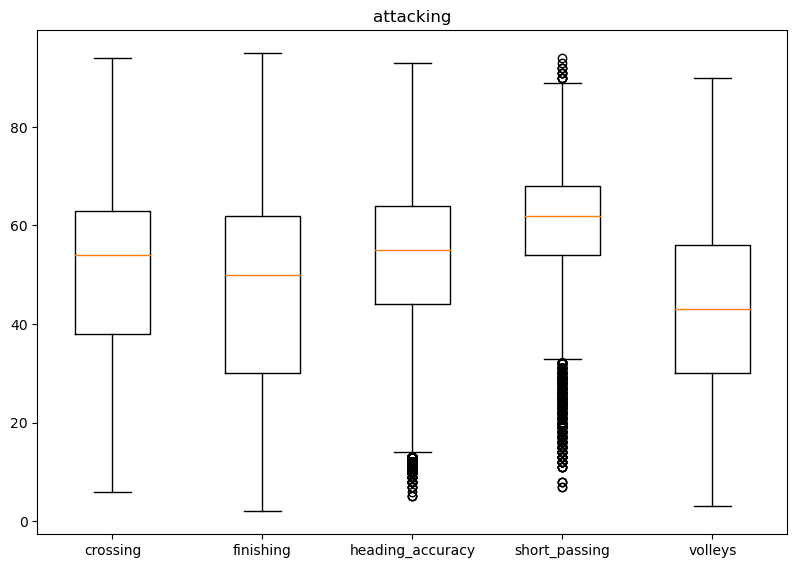

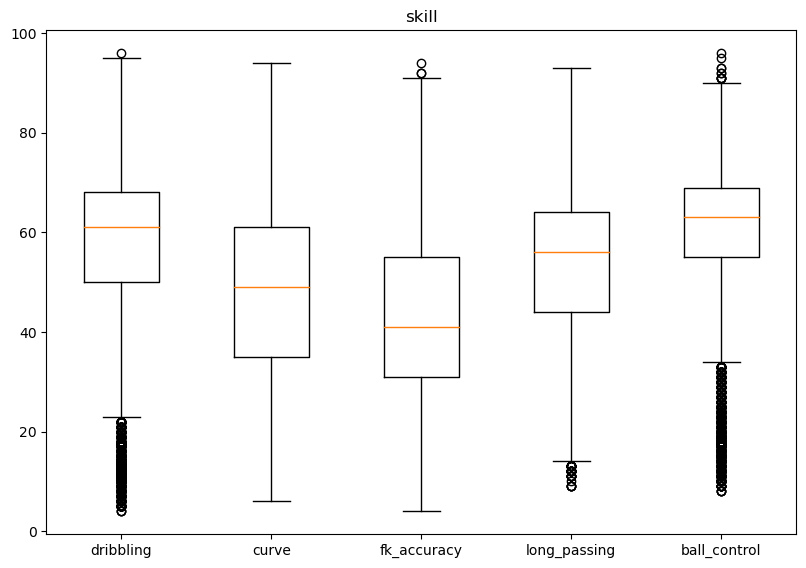

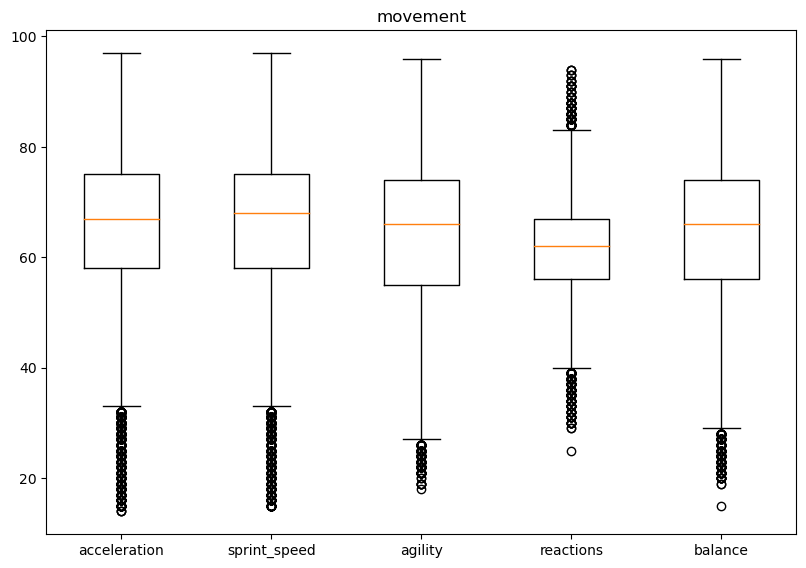

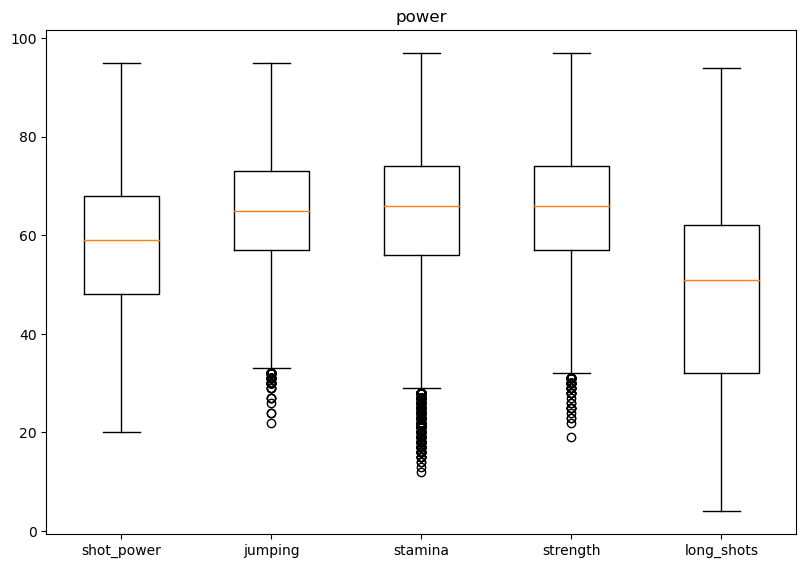

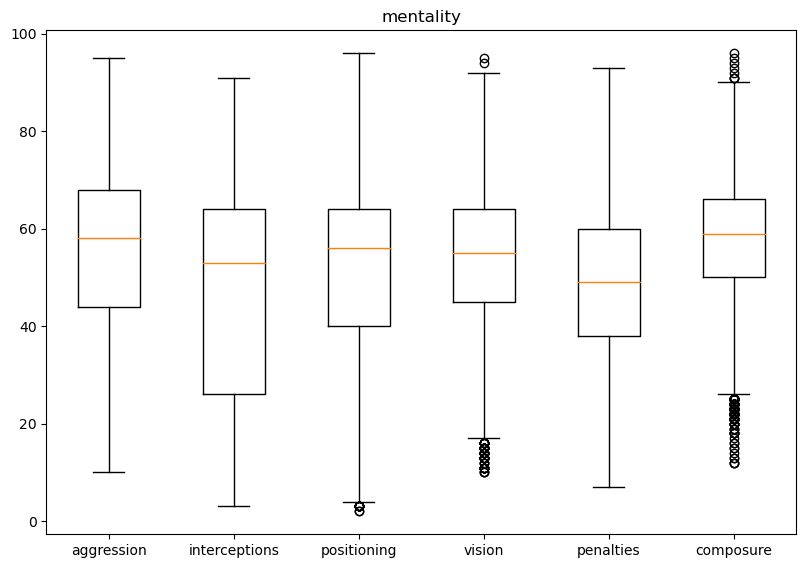

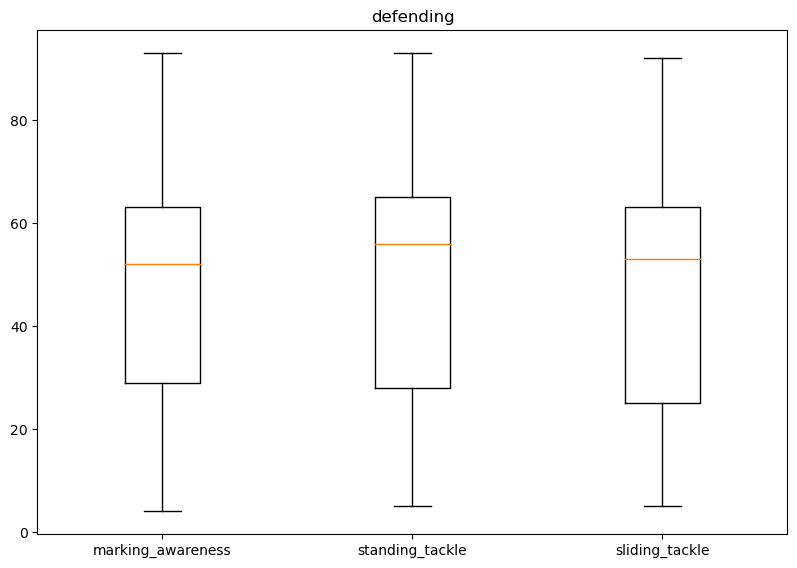

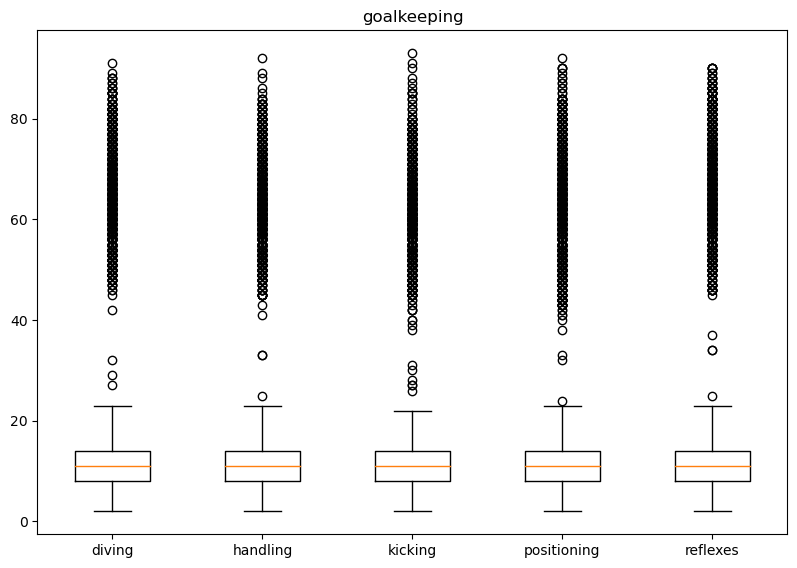

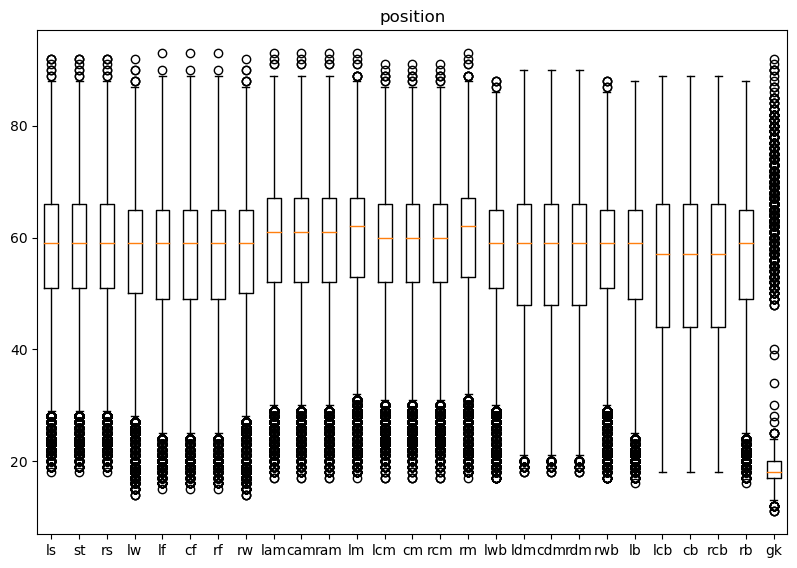

In [180]:
print(cols_dict.keys())
for key in cols_dict.keys():
    if key not in ['descriptive', 'features', 'all', 'others']:
        show_boxplot(df, key)

# Standaryzacja

In [181]:
from sklearn.preprocessing import StandardScaler

In [182]:
df_stand = df.copy()

col_drop_standard = [
    'short_name',
    'player_positions',
    'club_name',
    'league_name',
    'nationality_name',
]
df_stand =  df_stand.drop(columns = col_drop_standard)

df_stand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   value_eur                    19165 non-null  float64
 1   age                          19165 non-null  int64  
 2   height_cm                    19165 non-null  int64  
 3   weight_kg                    19165 non-null  int64  
 4   league_level                 19165 non-null  float64
 5   weak_foot                    19165 non-null  int64  
 6   skill_moves                  19165 non-null  int64  
 7   international_reputation     19165 non-null  int64  
 8   attacking_crossing           19165 non-null  int64  
 9   attacking_finishing          19165 non-null  int64  
 10  attacking_heading_accuracy   19165 non-null  int64  
 11  attacking_short_passing      19165 non-null  int64  
 12  attacking_volleys            19165 non-null  int64  
 13  skill_dribbling      

In [183]:
scaler = StandardScaler()
data_1 = df_stand.iloc[:,:]
data_stand = scaler.fit_transform(data_1)
data_stand

C:\Users\karno\miniconda3\envs\neuralnetwork\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\karno\miniconda3\envs\neuralnetwork\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\karno\miniconda3\envs\neuralnetwork\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\karno\miniconda3\envs\neuralnetwork\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be rem

array([[ 9.87056351,  1.86359972, -1.64518018, ..., -0.09175446,
         0.60450243, -0.08375154],
       [15.32140647,  1.44053345,  0.54062014, ...,  0.58798046,
         0.60450243, -0.08375154],
       [ 5.53615826,  2.28666598,  0.83206018, ...,  0.11216602,
         0.53345973, -0.01738129],
       ...,
       [-0.36125978, -0.886331  , -0.47942001, ..., -0.49959541,
        -0.46113814, -0.61471362],
       [-0.35994632, -1.30939726, -1.20802011, ..., -1.79109176,
        -1.52677872, -0.41560284],
       [-0.35994632, -1.30939726, -2.08234024, ..., -0.77148938,
        -0.60322355, -0.34923258]])

# Wyznaczanie składowych głównych

In [184]:
from sklearn.decomposition import PCA

In [185]:
index_pca = [
 #'overall',
 #'potential',
 'value_eur',
 #'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation', 
 #'release_clause_eur',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',  
 'goalkeeping_diving',
 'goalkeeping_handling', 
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm', 
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm' ,
 'rwb', 
 'lb',
 'lcb', 
 'cb',
 'rcb',
 'rb',
 'gk'
]

In [186]:
pca = PCA()
pca_data = pca.fit_transform(data_stand)
n_components = len(pca.components_)
pca_cols = [f'PC{x+1}' for x in range(n_components)]
df_pca_componenets = pd.DataFrame(data=np.transpose(pca.components_), columns=pca_cols, index = index_pca)
df_pca_componenets.abs().sort_values(by='PC1',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
lcm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,0.075301,0.086452,0.034477,0.033840,0.004428,0.008940,0.018255,0.022146,0.033752,0.013189,0.048423,0.007703,0.003749,0.000124,0.002941,0.013661,0.003568,0.006204,0.019302,0.016392,0.013248,0.029647,0.007822,0.046734,0.011271,0.000656,0.000994,0.025339,0.000265,0.000385,0.001302,0.030707,0.120625,0.111023,0.420228,0.246783,0.028756,0.021539,0.056206,0.010580,0.015049,0.025203,0.003226,3.312511e-03,4.540775e-03,4.814663e-02,6.392280e-03,7.135009e-01,1.366855e-01,1.363206e-01,1.680470e-01,2.245344e-01,1.536820e-01,3.245486e-02,5.555844e-02,5.416088e-02,6.989227e-02,6.078134e-02,2.240849e-17
rcm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,0.075301,0.086452,0.034477,0.033840,0.004428,0.008940,0.018255,0.022146,0.033752,0.013189,0.048423,0.007703,0.003749,0.000124,0.002941,0.013661,0.003568,0.006204,0.019302,0.016392,0.013248,0.029647,0.007822,0.046734,0.011271,0.000656,0.000994,0.025339,0.000265,0.000385,0.001302,0.030707,0.120625,0.111023,0.420228,0.246783,0.028756,0.021539,0.056206,0.010580,0.015049,0.025203,0.003226,5.796325e-02,3.708692e-01,9.981739e-02,1.361863e-02,5.828854e-01,7.452713e-02,1.919732e-01,2.300620e-01,2.345491e-01,1.405273e-01,5.819680e-02,3.671073e-02,2.797434e-02,1.274232e-02,9.017272e-03,9.620135e-18
cm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,0.075301,0.086452,0.034477,0.033840,0.004428,0.008940,0.018255,0.022146,0.033752,0.013189,0.048423,0.007703,0.003749,0.000124,0.002941,0.013661,0.003568,0.006204,0.019302,0.016392,0.013248,0.029647,0.007822,0.046734,0.011271,0.000656,0.000994,0.025339,0.000265,0.000385,0.001302,0.030707,0.120625,0.111023,0.420228,0.246783,0.028756,0.021539,0.056206,0.010580,0.015049,0.025203,0.003226,6.127576e-02,3.754100e-01,1.479640e-01,7.226348e-03,1.306154e-01,2.112126e-01,3.282938e-01,6.201500e-02,4.590834e-01,2.942093e-01,9.065166e-02,9.226917e-02,8.213523e-02,5.714995e-02,5.176407e-02,2.486291e-17
lm,0.149650,0.065638,0.004215,0.019791,0.020403,0.002560,0.009764,0.065119,0.037795,0.022374,0.044233,0.047756,0.033948,0.000674,0.057012,0.011735,0.027144,0.018073,0.034414,0.033383,0.005980,0.044822,0.045451,0.031068,0.005926,0.003283,0.028354,0.009577,0.002743,0.046654,0.004629,0.006859,0.010042,0.008406,0.030931,0.016102,0.005879,0.019553,0.001105,0.000660,0.001523,0.002018,0.048981,0.219245,0.113203,0.019277,0.077162,0.602622,0.062628,0.029563,0.008093,0.079568,0.004687,2.271772e-03,5.543547e-03,9.998528e-03,1.560217e-02,3.839249e-02,2.600641e-01,1.797993e-02,1.145583e-01,1.289663e-01,2.747055e-01,2.755100e-01,1.482480e-02,1.397247e-01,1.584285e-01,4.519104e-01,1.957050e-16
rm,0.149650,0.065638,0.004215,0.019791,0.020403,0.002560,0.009764,0.065119,0.037795,0.022374,0.044233,0.047756,0.033948,0.000674,0.057012,0.011735,0.027144,0.018073,0.034414,0.033383,0.005980,0.044822,0.045451,0.031068,0.005926,0.003283,0.028354,0.009577,0.002743,0.046654,0.004629,0.006859,0.010042,0.008406,0.030931,0.016102,0.005879,0.019553,0.001105,0.000660,0.001523,0.002018,0.048981,0.219245,0.113203,0.019277,0.077162,0.602622,0.062628,0.029563,0.008093,0.079568,0.004687,2.271772e-03,5.543547e-03,9.998528e-03,1.560217e-02,3.839249e-02,2.600641e-01,1.797993e-02,1.145583e-01,1.289663e-01,2.747055e-01,2.755100e-01,1.482480e-02,1.397247e-01,1.584285e-01,4.519104e-01,6.769513e-17
skill_ball_control,0.147965,0.037445,0.001415,0.031102,0.012738,0.049336,0.002366,0.016928,0.012672,0.022133,0.126370,0.067247,0.049453,0.033726,0.002648,0.041176,0.038468,0.055359,0.014161,0.050306,0.012542,0.097767,0.01

In [187]:
df_pca_componenets.abs().sort_values(by='PC2',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
defending_sliding_tackle,0.084976,0.258602,0.053252,0.102452,0.050891,0.025947,0.021764,0.000116,0.008514,0.005378,0.093298,0.049754,0.015571,0.092369,0.029709,0.007682,0.070038,0.050692,0.056332,0.049256,0.101442,0.086924,0.019002,0.006594,0.027198,0.008081,0.019160,0.013194,0.000951,0.004911,0.181541,0.354712,0.072732,0.192434,0.232529,0.264385,0.020275,0.000845,0.002703,0.007867,0.021743,0.656519,0.034470,0.001280,0.046077,0.054581,0.014654,0.000518,0.242366,0.021060,0.166545,0.067559,0.010447,2.727339e-15,2.463619e-16,1.179584e-16,2.884112e-19,2.508697e-17,4.772895e-17,1.033309e-16,3.099326e-18,4.469611e-17,3.238097e-17,3.090736e-18,1.918855e-17,4.275546e-17,2.584159e-17,7.755952e-18,7.422058e-18
defending_standing_tackle,0.090044,0.253757,0.041743,0.094096,0.060666,0.031994,0.027463,0.001711,0.009659,0.000165,0.083890,0.054703,0.002824,0.071968,0.017840,0.023051,0.062868,0.014540,0.064947,0.052214,0.095766,0.109838,0.003713,0.005336,0.035493,0.052343,0.021017,0.003469,0.001892,0.000018,0.139845,0.310255,0.075727,0.123777,0.080255,0.180852,0.008204,0.046536,0.009364,0.017209,0.034548,0.708597,0.136162,0.009551,0.033068,0.192709,0.229186,0.021743,0.199957,0.036883,0.140520,0.074104,0.007689,3.461552e-16,5.789860e-17,6.021334e-17,4.628623e-18,4.426588e-17,2.543483e-17,3.308712e-17,1.476578e-17,4.312581e-17,4.281505e-18,2.699526e-17,4.055890e-17,6.573205e-17,3.699859e-17,2.207962e-17,5.367833e-18
mentality_interceptions,0.089632,0.251947,0.003086,0.106957,0.054085,0.011860,0.013533,0.010271,0.000385,0.014725,0.059737,0.059010,0.001975,0.052228,0.025842,0.042177,0.050967,0.038355,0.049021,0.068272,0.070759,0.137644,0.061033,0.032987,0.022309,0.063523,0.018097,0.052620,0.012075,0.060182,0.021865,0.031788,0.049294,0.375374,0.373988,0.614010,0.041704,0.103852,0.003923,0.011023,0.007615,0.141478,0.060547,0.031081,0.064858,0.091101,0.215093,0.017951,0.261903,0.038907,0.125342,0.076708,0.009027,2.140933e-15,7.083475e-17,1.101542e-16,1.471364e-17,4.564594e-17,2.487770e-18,1.300658e-16,3.942818e-17,1.670844e-16,4.361258e-17,1.231826e-16,1.123066e-17,1.128435e-17,2.352797e-17,6.847106e-17,2.886246e-17
defending_marking_awareness,0.093212,0.245470,0.017209,0.081792,0.042106,0.000940,0.018638,0.020385,0.000318,0.028834,0.037877,0.052643,0.023111,0.050806,0.019980,0.017121,0.021247,0.012399,0.070658,0.079841,0.116059,0.080268,0.043937,0.036924,0.026706,0.035115,0.013362,0.055397,0.085439,0.019493,0.168016,0.804514,0.120787,0.122397,0.200936,0.160374,0.001039,0.021889,0.004208,0.006065,0.001135,0.026867,0.103716,0.011976,0.066205,0.108758,0.159821,0.016959,0.167726,0.027228,0.087781,0.051968,0.004223,1.626919e-15,7.431999e-17,2.919062e-17,4.811701e-17,1.422263e-17,4.026438e-17,1.607697e-17,9.664952e-17,3.497899e-18,1.735180e-20,1.161836e-17,1.330054e-17,1.424030e-17,1.987326e-18,1.655999e-17,6.077955e-18
lcb,0.111830,0.225956,0.015717,0.007569,0.005476,0.007622,0.002198,0.006312,0.003111,0.016409,0.035192,0.058795,0.005297,0.044388,0.018799,0.019421,0.030723,0.020187,0.006455,0.022708,0.040777,0.078586,0.019447,0.012443,0.006232,0.006288,0.003405,0.043724,0.019342,0.004838,0.004256,0.019680,0.004008,0.000768,0.005397,0.013560,0.000090,0.001382,0.000287,0.003478,0.000906,0.060902,0.267971,0.042394,0.161548,0.367506,0.083379,0.012402,0.037454,0.024874,0.006355,0.025103,0.005575,1.878724e-02,1.071495e-01,5.288037e-02,8.505648e-02,4.739360e-02,3.012829e-01,2.132690e-01,1.764279e-01,3.847651e-01,5.376821e-01,3.653703e-02,1.043573e-03,6.426480e-02,1.110115e-02,1.801063e-01,2.258887e-17
rcb,0.111830,0.225956,0.015717,0.007569,0.005476,0.007622,0.002198,0.006312,0.003111,0.016409,0.035192,0.058795,0.005297,0.044388,0

In [188]:
df_pca_componenets.abs().sort_values(by='PC3',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
movement_reactions,0.076632,0.020014,0.328813,0.116093,0.124714,0.082998,0.045822,0.080644,0.018316,0.056926,0.312904,0.276796,0.318144,0.154359,0.114957,0.017969,0.188774,0.232546,0.081345,0.163496,0.279347,0.130168,0.290641,0.240833,0.117803,0.161990,0.111756,0.237331,0.085368,0.111014,0.053070,0.036514,0.018283,0.053284,0.064817,0.010956,0.020943,0.021701,0.010507,0.009116,0.005793,0.000705,0.033473,0.010915,0.022910,0.020731,0.026917,0.002682,0.039977,0.047515,0.022274,0.111478,0.053477,8.057640e-16,6.237166e-17,6.570317e-17,5.295056e-18,1.579120e-17,2.625980e-17,2.872692e-17,3.973825e-17,5.345732e-17,2.294068e-17,9.325953e-18,1.456224e-20,2.434840e-17,4.200199e-17,1.751616e-17,4.244098e-18
age,0.020756,0.038243,0.279940,0.016591,0.149668,0.423543,0.147634,0.234425,0.289374,0.546265,0.228207,0.021803,0.094054,0.148274,0.146222,0.070447,0.109516,0.232823,0.142650,0.170265,0.074015,0.080788,0.038667,0.002447,0.082199,0.026176,0.030506,0.017737,0.070375,0.042362,0.006522,0.051608,0.001050,0.016600,0.021767,0.008722,0.003364,0.012042,0.009859,0.000092,0.002299,0.009739,0.005719,0.009231,0.010113,0.017472,0.009373,0.003013,0.003817,0.002698,0.000707,0.005655,0.003232,1.423613e-16,9.847733e-18,2.984278e-17,6.924130e-18,1.228938e-17,1.496831e-17,1.380954e-17,9.719053e-19,6.376931e-18,1.182239e-17,5.275135e-18,7.907666e-18,1.994918e-18,2.079618e-17,1.227799e-17,1.849966e-17
weight_kg,0.050361,0.096877,0.264321,0.315226,0.014973,0.033282,0.066380,0.166025,0.155118,0.219241,0.167475,0.247491,0.000337,0.056344,0.152312,0.317233,0.553576,0.103329,0.048458,0.221782,0.133822,0.041367,0.180653,0.204915,0.155643,0.010131,0.036929,0.089605,0.011144,0.007653,0.004453,0.004702,0.001503,0.001896,0.010050,0.010404,0.000415,0.004596,0.002828,0.001465,0.002096,0.000390,0.000269,0.000833,0.001077,0.000798,0.000107,0.000979,0.000028,0.000070,0.000158,0.000279,0.000761,1.042222e-16,5.024403e-17,3.307256e-17,4.885778e-18,3.083978e-17,1.440802e-17,1.297817e-17,2.243300e-17,1.228083e-17,1.991515e-17,1.176583e-17,2.161856e-17,2.198457e-17,5.888896e-18,1.264960e-17,6.875170e-18
international_reputation,0.033504,0.005070,0.245581,0.124096,0.295372,0.404311,0.092136,0.298468,0.342932,0.241682,0.031273,0.247314,0.283189,0.345265,0.162843,0.180007,0.036122,0.238545,0.020726,0.110817,0.008174,0.065765,0.012112,0.034450,0.011694,0.002462,0.022999,0.011274,0.002899,0.018826,0.004997,0.004172,0.000293,0.012777,0.000231,0.004306,0.003285,0.001799,0.000470,0.000521,0.000960,0.000575,0.008503,0.003744,0.000656,0.006496,0.006546,0.002108,0.008375,0.003211,0.004328,0.005857,0.004850,1.147449e-16,2.716570e-17,3.982361e-18,7.687073e-18,6.043831e-19,6.225091e-18,4.650013e-18,1.750638e-19,9.740521e-19,2.839159e-18,4.402122e-18,1.291747e-17,4.799856e-18,1.497818e-18,3.701387e-18,8.721681e-18
power_strength,0.027795,0.150321,0.234130,0.350121,0.104943,0.110561,0.015736,0.097568,0.094898,0.098101,0.071724,0.004825,0.119701,0.328581,0.235500,0.021756,0.087629,0.033746,0.030567,0.596671,0.324215,0.084355,0.186715,0.085162,0.038933,0.004610,0.022248,0.137001,0.016740,0.014273,0.003388,0.031291,0.008758,0.001236,0.024693,0.010149,0.002080,0.006678,0.000308,0.003969,0.000400,0.026139,0.015237,0.028101,0.059979,0.096609,0.074102,0.010995,0.009159,0.015513,0.002553,0.019343,0.001703,5.029226e-16,2.230780e-17,1.182089e-16,2.752330e-17,2.005718e-17,9.193303e-18,1.258165e-17,2.571880e-17,3.205200e-17,9.528315e-18,3.936122e-17,2.017364e-17,2.666623e-17,1.104103e-17,1.970911e-19,1.298621e-17
gk,0.123428,0.032175,0.228487,0.187685,0.018691,0.089565,0.016701,0.094755,0.069733,0.039808,0.031607,0.053784,0.006426,0.060772,0.023401,0.044721,0.032937,0.018793,

In [189]:
df_pca_componenets.abs().sort_values(by='PC4',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
power_strength,0.027795,0.150321,0.234130,0.350121,0.104943,0.110561,0.015736,0.097568,0.094898,0.098101,0.071724,0.004825,0.119701,0.328581,0.235500,0.021756,0.087629,0.033746,0.030567,0.596671,0.324215,0.084355,0.186715,0.085162,0.038933,0.004610,0.022248,0.137001,0.016740,0.014273,0.003388,0.031291,0.008758,0.001236,0.024693,0.010149,0.002080,0.006678,0.000308,0.003969,0.000400,0.026139,0.015237,0.028101,0.059979,0.096609,0.074102,0.010995,0.009159,0.015513,0.002553,0.019343,0.001703,5.029226e-16,2.230780e-17,1.182089e-16,2.752330e-17,2.005718e-17,9.193303e-18,1.258165e-17,2.571880e-17,3.205200e-17,9.528315e-18,3.936122e-17,2.017364e-17,2.666623e-17,1.104103e-17,1.970911e-19,1.298621e-17
height_cm,0.063633,0.108365,0.218849,0.323436,0.007295,0.141567,0.147440,0.191184,0.188166,0.056259,0.087550,0.166831,0.112746,0.177458,0.181444,0.081801,0.260782,0.048386,0.047989,0.356513,0.080884,0.052305,0.258183,0.400508,0.353893,0.008564,0.132624,0.114764,0.044842,0.007696,0.015521,0.007319,0.013560,0.001769,0.009079,0.022392,0.003467,0.009390,0.001323,0.001340,0.004187,0.001784,0.000346,0.000333,0.001331,0.000048,0.000289,0.000099,0.000092,0.000760,0.000172,0.000387,0.000011,3.054397e-16,5.518726e-17,4.682147e-17,1.149908e-17,4.309760e-17,9.504339e-18,7.380011e-19,1.978598e-17,2.260739e-17,5.304412e-18,2.322474e-17,1.137763e-17,4.093117e-19,7.089950e-18,3.271803e-17,1.126905e-17
weight_kg,0.050361,0.096877,0.264321,0.315226,0.014973,0.033282,0.066380,0.166025,0.155118,0.219241,0.167475,0.247491,0.000337,0.056344,0.152312,0.317233,0.553576,0.103329,0.048458,0.221782,0.133822,0.041367,0.180653,0.204915,0.155643,0.010131,0.036929,0.089605,0.011144,0.007653,0.004453,0.004702,0.001503,0.001896,0.010050,0.010404,0.000415,0.004596,0.002828,0.001465,0.002096,0.000390,0.000269,0.000833,0.001077,0.000798,0.000107,0.000979,0.000028,0.000070,0.000158,0.000279,0.000761,1.042222e-16,5.024403e-17,3.307256e-17,4.885778e-18,3.083978e-17,1.440802e-17,1.297817e-17,2.243300e-17,1.228083e-17,1.991515e-17,1.176583e-17,2.161856e-17,2.198457e-17,5.888896e-18,1.264960e-17,6.875170e-18
attacking_heading_accuracy,0.112179,0.099312,0.022750,0.297895,0.100684,0.016027,0.091243,0.101447,0.088842,0.087898,0.138592,0.125981,0.081311,0.140316,0.086007,0.064068,0.033437,0.078312,0.008450,0.079111,0.021822,0.024281,0.014841,0.110004,0.060081,0.247714,0.119966,0.751779,0.012722,0.114310,0.099230,0.030200,0.083105,0.073244,0.067191,0.047069,0.010904,0.032300,0.007095,0.000368,0.000866,0.010013,0.029598,0.071079,0.102878,0.171820,0.013758,0.016978,0.010387,0.050613,0.047446,0.059548,0.000302,4.615510e-16,8.419565e-17,1.832164e-16,1.479000e-18,2.865186e-17,4.813763e-17,7.418483e-17,4.618208e-17,1.443146e-16,1.617971e-17,1.259141e-16,3.685164e-17,2.624167e-17,3.915061e-17,2.235575e-17,1.027347e-18
movement_balance,0.097691,0.100550,0.167483,0.242378,0.121694,0.151105,0.020434,0.108256,0.109498,0.039724,0.025086,0.017515,0.008313,0.114188,0.345405,0.271982,0.326075,0.201518,0.067185,0.075083,0.089770,0.008916,0.071186,0.344700,0.567140,0.011293,0.074064,0.050750,0.039743,0.027813,0.011690,0.004731,0.029746,0.003346,0.017390,0.005450,0.004944,0.006426,0.006605,0.006215,0.001997,0.004575,0.000415,0.001070,0.002527,0.002495,0.001274,0.001939,0.000156,0.000292,0.000051,0.000075,0.000176,6.897168e-16,1.351855e-18,2.483288e-17,1.315026e-17,8.458593e-19,4.103811e-17,1.924683e-18,4.306756e-18,2.557758e-17,4.806227e-18,9.093635e-18,1.532642e-17,3.813384e-18,3.451207e-17,9.695231e-18,2.351477e-17
gk,0.123428,0.032175,0.228487,0.187685,0.018691,0.089565,0.016701,0.094755,0.069733,0.039808,0.031607,0.053784,0.006426,0.060772,0.023401,0.044721,0.032937,0.0

# Kryterium wartości własnej

In [190]:
print(pca_cols[:10])
print(pca.explained_variance_[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[42.33628323  9.07174188  4.3033168   2.50036375  1.34233797  1.20160446
  0.9715653   0.85647258  0.8115265   0.58752956]


# Kryterium częsci wyjaśnionej wariancji

In [191]:
print(pca_cols[:10])
print(np.cumsum(pca.explained_variance_ratio_)[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[0.61353731 0.74500497 0.80736862 0.84360389 0.86305705 0.88047069
 0.89455062 0.90696262 0.91872326 0.92723773]


# Kryterium minimalnego zasobu zmienności

In [192]:
pd.set_option('display.max_rows', None) # wyświetlanie wszyskich wierszów
pd.set_option('display.max_columns', None) # wyświetlanie wszyskich kolumn
pcaS = df_pca_componenets.pow(2).cumsum(axis=1)
pcaS

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
value_eur,0.001858,0.001983,0.051841,0.074619,0.233170,0.437964,0.453061,0.455051,0.463806,0.468591,0.470928,0.528394,0.532585,0.807566,0.842566,0.882431,0.882885,0.966565,0.967958,0.991029,0.991036,0.997623,0.997623,0.998111,0.998535,0.998535,0.998595,0.999033,0.999136,0.999179,0.999179,0.999298,0.999313,0.999805,0.999860,0.999890,0.999908,0.999909,0.999911,0.999911,0.999911,0.999913,0.999952,0.999966,0.999966,0.999971,0.999985,0.999986,0.999989,0.999990,0.999991,0.999997,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
age,0.000431,0.001893,0.080260,0.080535,0.102936,0.282324,0.304120,0.359075,0.442812,0.741218,0.793296,0.793772,0.802618,0.824603,0.845984,0.850947,0.862941,0.917147,0.937496,0.966486,0.971965,0.978491,0.979986,0.979992,0.986749,0.987434,0.988365,0.988680,0.993632,0.995427,0.995469,0.998133,0.998134,0.998409,0.998883,0.998959,0.998970,0.999115,0.999213,0.999213,0.999218,0.999313,0.999346,0.999431,0.999533,0.999838,0.999926,0.999935,0.999950,0.999957,0.999958,0.999990,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
height_cm,0.004049,0.015792,0.063687,0.168298,0.168351,0.188392,0.210131,0.246682,0.282088,0.285254,0.292919,0.320751,0.333463,0.364954,0.397876,0.404567,0.472575,0.474916,0.477219,0.604321,0.610863,0.613599,0.680257,0.840664,0.965904,0.965977,0.983567,0.996737,0.998748,0.998807,0.999048,0.999102,0.999286,0.999289,0.999371,0.999873,0.999885,0.999973,0.999975,0.999976,0.999994,0.999997,0.999997,0.999997,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
weight_kg,0.002536,0.011921,0.081787,0.181155,0.181379,0.182486,0.186893,0.214457,0.238518,0.286585,0.314633,0.375885,0.375885,0.379059,0.402258,0.502895,0.809342,0.820019,0.822367,0.871555,0.889463,0.891174,0.923809,0.965800,0.990025,0.990127,0.991491,0.999520,0.999644,0.999703,0.999723,0.999745,0.999747,0.999751,0.999852,0.999960,0.999960,0.999981,0.999989,0.999991,0.999996,0.999996,0.999996,0.999997,0.999998,0.999998,0.999998,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
league_level,0.000098,0.000103,0.005076,0.012391,0.013864,0.088587,0.934385,0.934496,0.977072,0.979406,0.986519,0.989105,0.989795,0.990433,0.990499,0.990525,0.990811,0.993155,0.993349,0.996175,0.996278,0.996473,0.997840,0.999102,0.999446,0.999446,0.999662,0.999811,0.999823,0.999850,0.999857,0.999860,0.999861,0.999922,0.999965,0.999965,0.999974,0.999986,0.999986,0.999994,0.999994,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
weak_foot,0.002802,0.007511,0.010966,0.010980,0.012238,0.013861,0.032134,0.512558,0.989191,0.990867,0.991680,0.995349,0.997318,0.997685,0.998333,0.998340,0.998879,0.999032,0.999428,0.999464,0.999567,0.999625,0.999627,0.999687,0.999692,0.999700,0.999723,0.999806,0.999815,0.999819,0.999849,0.999917,0.999918,0.999937,0.999939,0.999959,0.999986,0.999986,0.999987,0.999988,0.999994,0.999995,0.999997,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

# Analiza czynnikowa

In [193]:
pip install factor_analyzer

Note: you may need to restart the kernel to use updated packages.


In [194]:
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Wyliczenie współczynników FA

In [195]:
fa = FactorAnalysis(random_state=1)
data_transformed = fa.fit_transform(data_stand)
n_components = len(fa.components_)
fa_cols = [f'F{x+1}' for x in range(n_components)]
df_fa_componenets = pd.DataFrame(data=np.transpose(fa.components_), columns=fa_cols, index = index_pca)
df_fa_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69
value_eur,-0.303156,-0.022529,0.120208,0.193661,0.304730,-0.001790,-0.167467,-0.051140,-0.019770,-0.130254,0.031689,0.172006,0.129783,0.145742,0.061559,0.120992,0.542792,0.027108,-0.076117,0.063213,0.053917,-0.032657,-0.074478,-0.003516,0.070845,0.014688,0.005628,0.097439,-0.012008,-0.021495,0.023215,0.008020,-0.004410,0.007504,-1.864956e-02,0.010774,0.005058,-0.004317,0.022492,-0.024922,-0.014531,-6.759756e-03,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
age,-0.153628,0.103081,0.035735,0.375882,0.321486,-0.083250,0.095493,0.098598,0.104966,0.146495,0.000786,-0.195570,0.097389,0.111533,0.145889,0.197489,-0.241760,-0.100051,-0.030593,0.046968,-0.107205,-0.176593,0.156183,-0.136822,0.098988,0.041705,0.097087,-0.119887,0.012032,0.027687,-0.070643,-0.004756,0.025927,-0.007081,4.852030e-02,-0.011169,-0.024798,0.019762,-0.016148,0.007161,-0.000218,-8.999541e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
height_cm,0.387460,0.231392,-0.243932,0.472998,0.068735,-0.008955,-0.171220,0.093612,0.110532,-0.107269,0.186140,0.077297,0.194567,-0.403518,0.043243,0.068489,0.048275,-0.030249,0.045924,-0.025301,-0.014465,0.030242,-0.099361,-0.060479,-0.017495,-0.089944,-0.087021,-0.033346,-0.000502,0.000958,0.009824,0.005267,0.007749,0.007478,2.201332e-03,-0.010892,0.008982,0.011875,-0.002980,-0.005753,-0.000592,6.033654e-03,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
weight_kg,0.299749,0.198162,-0.241957,0.505209,0.139343,-0.007474,-0.165885,0.100720,0.171851,-0.070217,0.159231,-0.001716,0.175154,-0.356654,0.087719,0.057318,0.012312,-0.051707,-0.015853,0.035573,-0.074202,-0.056913,0.021813,-0.051795,0.034057,-0.005628,-0.075300,-0.052754,0.027352,0.025472,0.056475,-0.011309,-0.036684,0.006689,-2.234806e-03,0.044847,-0.067366,-0.052025,0.025313,0.021893,0.015445,3.696419e-03,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
league_level,0.073195,-0.000018,-0.066358,-0.077111,-0.076040,0.004917,-0.014765,-0.009667,0.008188,0.014130,-0.014689,-0.118959,-0.027241,-0.088250,-0.025616,-0.021849,0.000139,-0.066355,0.059636,0.003199,-0.011192,-0.034701,-0.024136,-0.036981,0.025354,-0.089076,-0.159081,-0.036351,0.045470,-0.012346,0.067821,0.005597,-0.028670,0.160340,1.750711e-01,0.015283,0.127769,0.092995,-0.047333,-0.005797,0.005921,-4.596898e-02,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
weak_foot,-0.342112,-0.180711,0.034544,0.056935,0.025246,-0.011782,-0.007670,-0.007877,0.019454,0.012794,-0.048720,-0.026820,0.021831,0.020919,0.061642,0.006442,0.034487,-0.025911,0.054933,0.023468,0.010563,-0.018338,0.015832,-0.025840,0.028379,-0.058094,-0.009328,0.021913,-0.000018,-0.006308,-0.016388,0.036947,0.007725,-0.023254,-3.421197e-02,0.069394,0.074782,0.089541,0.079225,0.105368,0.080692,-8.026621e-03,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
skill_moves,-0.758210,-0.291566,0.016102,-0.094042,-0.020834,-0.019009,0.046966,0.004859,0.046603,0.059216,-0.033946,-0.004373,0.060541,0.021955,0.085390,0.016006,0.104811,-0.062081,0.037924,0.009045,-0.029942,-0.002614,0.045871,0.023566,-0.047254,-0.052006,0.004883,0.010771,0.029633,-0.003939,-0.040922,-0.016572,0.016666,-0.089775,-2.529520e-02,0.084266,0.017127,0.052306,-0.001473,0.018292,0.000641,3.602790e-02,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,

# Rotacja varimax

In [196]:
fav = FactorAnalysis(random_state=1, rotation = 'varimax')
data_transformed = fav.fit_transform(data_stand)
n_components = len(fav.components_)
fav_cols = [f'F{x+1}' for x in range(n_components)]
df_fav_componenets = pd.DataFrame(data=np.transpose(fav.components_), columns=fav_cols, index = index_pca)
df_fav_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69
value_eur,-0.267013,0.137479,-0.021462,0.069246,0.198188,0.006679,-0.038555,0.008855,0.002069,0.005039,-0.009575,-0.046774,0.075072,-0.043318,0.000395,-0.131037,0.732308,-0.007537,-0.009948,0.002955,-0.005403,-0.012221,0.025774,-0.002333,-0.049289,0.017418,0.005520,-0.027231,-0.002015,-0.001611,0.002809,0.002023,1.466310e-03,2.673979e-04,-0.025378,-0.001937,-3.283912e-05,-0.003881,0.005520,0.010336,0.004624,-0.000647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,-0.147084,0.163728,-0.113078,0.204383,0.311237,0.002727,-0.009965,0.018346,0.013215,0.022570,-0.000763,-0.014390,0.043082,0.144655,0.019837,0.661516,0.007976,0.000842,0.001774,-0.000562,-0.001265,-0.000946,-0.000529,-0.000397,-0.000249,0.001428,0.003721,-0.001448,0.000140,-0.000061,0.000853,-0.000023,4.261597e-05,2.471024e-05,-0.005308,0.000331,-4.483001e-06,-0.000062,0.001375,0.001973,0.000030,-0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height_cm,0.366616,-0.044966,0.046070,0.798621,0.107494,0.001450,0.153682,-0.014701,-0.024884,-0.003091,-0.008023,0.017300,0.018694,0.093116,-0.009360,-0.076916,0.057199,0.014640,0.002743,-0.000546,-0.000459,-0.004433,-0.011336,0.005910,-0.006838,-0.007975,0.032836,-0.007430,-0.012425,0.005615,-0.051977,0.001627,1.458186e-03,5.155005e-04,0.058473,0.011115,1.902812e-03,0.000376,0.023527,0.008497,0.001953,0.004840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight_kg,0.269586,-0.027643,-0.002120,0.799068,0.150425,-0.009136,0.042076,0.001374,-0.010069,-0.001189,-0.018260,0.023991,0.004749,0.069993,0.013988,0.089829,0.059126,-0.013954,0.006089,0.002824,0.005051,0.006362,0.006633,-0.002364,0.007251,0.003789,-0.043227,0.010171,0.011800,-0.005418,0.118955,-0.001616,-1.208141e-03,-4.462270e-04,0.014371,-0.009468,-1.907178e-03,0.001235,-0.011171,-0.006275,-0.001834,-0.004808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
league_level,0.067594,-0.043759,-0.039218,0.029597,-0.085080,0.010611,0.013256,0.000265,-0.012225,0.023307,-0.022527,-0.046050,-0.051278,-0.041148,-0.016578,-0.026805,-0.099520,-0.000063,0.000304,-0.003513,0.000099,-0.001388,-0.000015,0.013409,0.000152,0.001405,-0.021445,-0.001668,0.000601,-0.000053,0.005678,0.000014,-1.107957e-05,-3.216715e-06,0.387982,-0.001357,-4.111470e-06,0.000069,-0.000434,0.006943,-0.000011,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weak_foot,-0.385249,0.028066,-0.052931,-0.018542,-0.004137,0.020860,0.001588,-0.013449,-0.010544,0.042726,-0.015378,-0.008971,-0.002860,-0.021676,0.004709,0.036559,0.066043,0.000563,0.009772,0.004745,0.010003,-0.007627,-0.000920,-0.053478,-0.000259,-0.000379,0.005912,-0.002787,-0.002161,0.000269,0.001727,0.000311,-3.116074e-05,7.976242e-06,0.033723,0.018846,1.042483e-05,-0.000270,0.005866,0.233738,-0.000020,-0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
skill_moves,-0.768039,0.158216,0.034918,-0.126011,-0.164162,0.006458,-0.009810,0.031103,0.002269,0.097339,-0.070803,0.004495,0.038507,-0.104509,-0.017128,0.036907,0.092110,0.004707,-0.024643,-0.002103,0.024556,0.009507,-0.015369,0.002108,0.000133,-0.021784,-0.037562,0.009163,0.003015,-0.000759,0.009598,-0.000476,-1.782216e-04,6.351593e-05,-0.017592,0.156393,1.757203e-05,0.001316,0.048222,0.106252,-0.000952,0.000064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
international_reputation,-0.210831,0.1090